# Requirements


In [1]:
 #!pip install datasets
 #!pip3 install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cpu
!pip install 'torchmetrics[image]'


In [2]:
import torch
import random

# Set random seed for reproducibility
manualSeed = 999
# manualSeed = random.randint(1, 10000)  # Use this if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True)  # Needed for reproducible results

# Check for CUDA
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Random Seed:  999
Using device: cuda:0


In [3]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader, ConcatDataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import pickle
import os

In [4]:
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [5]:
# Root directory for dataset
root_dir="cropped2"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 40

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

label_smoothing= False
label_flipping= False

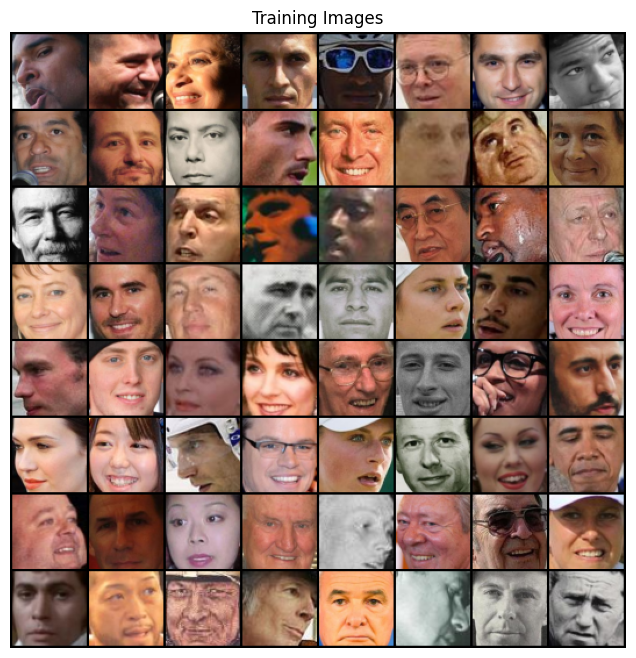

In [6]:
dataset = dset.ImageFolder(root=root_dir,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [7]:
print(f"Using device: {device}")
#print(f"netG is on: {next(netG.parameters()).device}")
#print(f"netD is on: {next(netD.parameters()).device}")

Using device: cuda:0


Weight Initialization

In [8]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

Generator

In [9]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

In [10]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


# Discriminator

In [11]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [12]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


Loss Functions and Optimizers


In [13]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
fake_label=0.0
alpha = 0.1
K = 2  # number of classes
if label_smoothing:
    real_label = 1.0 - alpha / K  # 0.95
    
    
else:
    real_label = 1.0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Computing Fréchet inception distance

In [14]:
import torch
import torchvision.transforms as transforms
from torchmetrics.image.fid import FrechetInceptionDistance
from torchvision.models import inception_v3
from torchvision.utils import save_image

# Ensure FID calculation happens in evaluation mode
fid_metric = FrechetInceptionDistance(feature=2048).to("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
def compute_fid(real_images, fake_images, fid_metric):
    """Computes FID between real and fake images."""
    
    real_images = (real_images * 255).byte()
    fake_images = (fake_images * 255).byte()
   
    # Update the metric with real and fake images
    fid_metric.update(real_images, real=True)
    fid_metric.update(fake_images, real=False)

    # Compute FID
    fid_score = fid_metric.compute()
    
    # Reset metric for next evaluation
    fid_metric.reset()
    
    return fid_score.item()


In [ ]:
# Lists to keep track of progress
print(f"Using device: {device}")
print(f"netG is on: {next(netG.parameters()).device}")
print(f"netD is on: {next(netD.parameters()).device}")
flip_prob = 0.05  # 5% label flipping
img_list = []
G_losses = []
D_losses = []
FID_scores = []
iters = 0
def show_generated_images(img_tensor, title=None):
    npimg = img_tensor.numpy()
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    if title:
        plt.title(title)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def flip_labels(labels, prob):
    # Create mask where flip_prob% of labels are flipped
    flip_mask = torch.rand_like(labels) < prob
    flipped = labels.clone()
    flipped[flip_mask] = 1.0 - labels[flip_mask]  # Flip 1<->0
    return flipped
    
print("Starting Training Loop...")
iter_counter=0
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        iters += 1
        iter_counter +=1
    checkpoint_path = "checkpointsdcgan/"
    os.makedirs(checkpoint_path, exist_ok=True)
    if (epoch + 1) % 5 == 0:
        save_data = {
            'epoch': epoch,
            'netG_state_dict': netG.state_dict(),
            'netD_state_dict': netD.state_dict(),
            'optimizerG_state_dict': optimizerG.state_dict(),
            'optimizerD_state_dict': optimizerD.state_dict(),
            'G_losses': G_losses,
            'D_losses': D_losses,
        }
        with open(f"{checkpoint_path}/dcgan_with_label_flipping_checkpoint_epoch_{epoch+1}.pkl", "wb") as f:
            pickle.dump(save_data, f)
        print(f"Checkpoint saved at epoch {epoch+1}")

Using device: cuda:0
netG is on: cuda:0
netD is on: cuda:0
Starting Training Loop...


[0/40][0/189]	Loss_D: 1.4636	Loss_G: 6.3086	D(x): 0.6203	D(G(z)): 0.5603 / 0.0025
[0/40][50/189]	Loss_D: 0.1088	Loss_G: 9.4598	D(x): 0.9576	D(G(z)): 0.0491 / 0.0001
[0/40][100/189]	Loss_D: 0.0305	Loss_G: 6.7524	D(x): 0.9922	D(G(z)): 0.0167 / 0.0097
[0/40][150/189]	Loss_D: 0.2555	Loss_G: 5.2151	D(x): 0.9065	D(G(z)): 0.1310 / 0.0069
[1/40][0/189]	Loss_D: 0.2848	Loss_G: 5.9067	D(x): 0.9409	D(G(z)): 0.1554 / 0.0053
[1/40][50/189]	Loss_D: 0.9719	Loss_G: 4.9984	D(x): 0.5185	D(G(z)): 0.0016 / 0.0227
[1/40][100/189]	Loss_D: 0.1886	Loss_G: 7.6494	D(x): 0.8805	D(G(z)): 0.0044 / 0.0005
[1/40][150/189]	Loss_D: 0.2467	Loss_G: 4.0130	D(x): 0.9174	D(G(z)): 0.1203 / 0.0242
[2/40][0/189]	Loss_D: 0.5345	Loss_G: 2.4956	D(x): 0.7942	D(G(z)): 0.1868 / 0.1270
[2/40][50/189]	Loss_D: 3.8060	Loss_G: 5.4248	D(x): 0.9724	D(G(z)): 0.9579 / 0.0107
[2/40][100/189]	Loss_D: 0.3738	Loss_G: 5.7153	D(x): 0.8842	D(G(z)): 0.1745 / 0.0052
[2/40][150/189]	Loss_D: 0.4702	Loss_G: 5.1180	D(x): 0.8754	D(G(z)): 0.2528 / 0.0084
[

# Evolution of the Frechet Distance

In [ ]:
import re
from tqdm import tqdm
torch.use_deterministic_algorithms(False)
# ---- Settings ----
checkpoint_dir = "checkpointsdcgan/"
checkpoint_pattern = r"dcgan_with_label_flipping_checkpoint_epoch_(\d+)\.pkl"
num_fid_batches = 10
batch_size = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- Collect all checkpoint paths and sort by epoch ----
checkpoints = []
for filename in os.listdir(checkpoint_dir):
    match = re.match(checkpoint_pattern, filename)
    if match:
        epoch_num = int(match.group(1))
        checkpoints.append((epoch_num, os.path.join(checkpoint_dir, filename)))

checkpoints.sort()  # Sort by epoch number

# ---- FID results storage ----
fid_results = []

# ---- Loop through each checkpoint ----
for epoch, path in checkpoints:
    print(f"\nEvaluating checkpoint: {path}")
    
    # Load checkpoint
    with open(path, "rb") as f:
        checkpoint = pickle.load(f)

    netG.load_state_dict(checkpoint['netG_state_dict'])
    netG.to(device)
    netG.eval()

    # Reset FID metric
    fid_metric = fid_metric.to(device)
    fid_metric.reset()

    # Generate and evaluate FID over multiple batches
    fid_scores = []
    real_iter = iter(dataloader)

    for _ in tqdm(range(num_fid_batches), desc=f"Epoch {epoch}"):
        with torch.no_grad():
            try:
                real_batch = next(real_iter)[0]
            except StopIteration:
                real_iter = iter(dataloader)
                real_batch = next(real_iter)[0]

            real_images = real_batch[:batch_size].to(device)
            noise = torch.randn(batch_size, nz, 1, 1, device=device)
            fake_images = netG(noise)

            score = compute_fid(real_images, fake_images, fid_metric)
            fid_scores.append(score)

    mean_fid = sum(fid_scores) / len(fid_scores)
    fid_results.append((epoch, mean_fid))
    print(f"✅ Epoch {epoch}: Mean FID = {mean_fid:.4f}")

# ---- Display results ----
print("\n=== Final FID Scores ===")
for epoch, score in fid_results:
    print(f"Epoch {epoch}: FID = {score:.4f}")

In [ ]:
# Extract epochs and scores from results
fid_epochs = [epoch for epoch, score in fid_results]
fid_scores = [score for epoch, score in fid_results]

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(fid_epochs, fid_scores, marker='o', linestyle='-')
plt.title("FID Score Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("FID Score")
plt.grid(True)
plt.tight_layout()
plt.show()

# Evolution of Generator and Discriminator Losses over Training

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
print(fake_label)

# Image Generator Evolution / Progression over the Epochs 

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

# Real Images vs Fake Images

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()